# Seismic petrophysics, part 1

## Introduction

This notebook shows how to create a synthetic dataset of elastic properties (Vp, Vs, density, etc.) starting from well logs. The idea is that the wells cannot possibly sample all the complexity and variations occurring across a reservoir. So what I do is to use various techniques to synthesize new data and create an _abstraction_ of my reservoir to investigate alternative and plausible scenarios (change of pore fluids; lithological variations) or create a training dataset to calibrate 3D seismic volumes. I think this would make sense if you are a geoscientist working in the oil industry with a keen interest in quantitative studies (at least for the terminology and the basic concepts I use here). 

What I also want to do is to demonstrate the use of Python to build your own tools and workflows and therefore move away from a "[black-box](http://en.wikipedia.org/wiki/Black_box) approach".

## The plan

The idea is to show how to do these things:

* import well log data and create a new lithology curve log;
* data augmentation through fluid-replacement modeling; 
* description of the reservoir complex under study through statistical analysis;
* creation of a synthetic dataset to replicate the overall behaviour of the reservoir complex.

And while doing this, I will also show some cool features of Python, using the Pandas library to explore geophysical data, defining evergreen functions like Gassmann and Voigt-Reuss-Hill, fancy plots, interactive tools, and all that jazz.

## Loading (and massaging) well data in Python

The well log I will use is part of the test datasets available on the Quantitative Seismic Interpretation book website:

<https://pangea.stanford.edu/researchgroups/srb/resources/books/quantitative-seismic-interpretation>

In particular, I use "Well 2", contained in the "Project Data" zipfile. Plenty of background information for this particular well is available on Per Avseth's PhD thesis, again available from the Stanford website:

<https://pangea.stanford.edu/researchgroups/srb/resources/theses>

The actual file I will load now, `qsiwell2.csv` is an elaboration of several other files contained in that zip archive (merged some logs, created others, etc.).

Now a few words on the libraries I am using:

* numpy
* matplotlib
* pandas

I use [Pandas](http://pandas.pydata.org/index.html) to digest log data; it's a library built to handle big datasets and make your life easier (as we shall see later). This is *my* way to do things. You are welcome to use Python's built-in structures if you're inclined to do so or need to keep things minimal (Matt and Evan at [Agile Geoscience](http://www.agilegeoscience.com) do [wonderful things](https://github.com/agile-geoscience/notebooks) relying on the standard triumvirate numpy/scipy/matplotlib).

For those interested in using their own `.las` files, there is another library (<http://wiki.scipy.org/Cookbook/LASReader>) that can be used.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

This is how I load `qsiwell2.csv` into a Pandas _DataFrame_ (that I will call `logs`):

In [3]:
logs = pd.read_csv('qsiwell2.csv')

and to check what's now inside `L`:

In [4]:
logs.columns

Index([u'DEPTH', u'VP', u'VS', u'RHO_OLD', u'GR', u'NPHI', u'RHO', u'SW', u'SWX', u'VPVS', u'IP', u'IS', u'VSH', u'RHOm', u'RHOf', u'PHI'], dtype='object')

As you can see, I have all the required logs for a quantitative analysis: the elastic logs (compressional and shear velocity `Vp` and `Vs`, density `RHO`) as well as the main petrophysical logs (water saturation `Sw`, shale volume `VSH` and porosity `PHI`).

Logs stored into a Pandas DataFrame are easily accessed using the syntax `DataFrame.log`, e.g. `L.VP` is the P-wave velocity log and `L.PHI` the porosity log.

To select more than one log, use the syntax `DataFrame.[['log1','log2']]`; an alternative is `DataFrame.ix[':',['log1','log2']]` which means selecting all the rows (indicated by `:`) of `log1` and `log2`. This second syntax allows to all kind of crazy selections and filtering like:

* `DataFrame.ix[(DataFrame.Z>=top) & (DataFrame.Z<=bottom)]`: to make a selection on the basis of the Z log (e.g., a depth curve), i.e. to perform a selection on the depth window `top`-`bottom`;
* `DataFrame.ix[DataFrame.class==4,['log1','log2']]`: to get `log1` and `log2` when `class` is 4 (assuming that `class` is a [categorical variable](http://en.wikipedia.org/wiki/Categorical_variable), for example a litho-facies log like the `LFC` log I have created earlier);
* `DataFrame[pd.notnull(DataFrame.log0)].ix[:,'log1','log2']`: to get `log1` and `log2` only when `log0` is not empty.

If I want to remove a specific log (e.g., that `RHO_OLD`) I use the `drop` method with the optional `axis=1` (required otherwise Pandas will search for a _row_ named `TVD` instead of a _column_; ys, Pandas allows):

In [5]:
logs = logs.drop(['RHO_OLD'], axis=1)

Let's check if I have really deleted `RHO_OLD`:

In [6]:
logs.columns

Index([u'DEPTH', u'VP', u'VS', u'GR', u'NPHI', u'RHO', u'SW', u'SWX', u'VPVS', u'IP', u'IS', u'VSH', u'RHOm', u'RHOf', u'PHI'], dtype='object')

To rename a log use the `.rename` method:

In [7]:
logs.rename(columns={'RHOf': 'RHOfluid'}, inplace=True)

But what if I need to rename multiple logs? Simply assign a new list of names to the DataFrame columns; for example, if I have a 3 logs called `log1`, `log2`, `log3`, I can rename them all in one go using this syntax:

    DataFrame.columns=['newlog1','newlog2','newlog3']
    
Some other useful functions of Pandas are `DataFrame.describe()`, `DataFrame.log.`.

What's great about Pandas however is that it simply is the best way I have ever seen to manage large and complex datasets;  the basic Dataframe is a compact, portable and powerful data structure that allows you to quickly inspect your data, either using standard Python functions (like `min()`, `.max()`, `.mean()`):

In [8]:
print("min", logs.DEPTH.min())
print("max", logs.DEPTH.max())
print("avg", logs.VP.mean())

('min', 2013.2528)
('max', 2640.5311999999999)
('avg', 2977.0987612339309)


...or something incredibly useful like the `describe` method:

In [9]:
logs[['VP','VS','RHO','PHI']].describe()

,VP,VS,RHO,PHI
count,4117.000000,4117.000000,2701.000000,2701.000000
mean,2977.098761,1371.293952,2.225045,0.291759
std,449.355552,297.056552,0.061961,0.032196
min,1439.900000,688.800000,2.036616,0.106844
25%,2594.500000,1141.600000,2.185285,0.276218
50%,3036.100000,1415.300000,2.223544,0.297311
75%,3251.100000,1595.000000,2.264000,0.310519
max,4431.000000,2427.800000,2.545268,0.376396


## Calculation of litho-facies log

The next step is to calculate a facies log, where by facies I mean a group of data identified not just by similar lithological properties but through a combination of properties such as lithology and pore fluids; for example brine sand and oil sand will be different facies. For this reason I like to use the term _Litho-Fluid Classes_ -- this is why my facies log will be called LFC:

* LFC=0: undef
* LFC=1: brine sand
* LFC=2: oil sand
* LFC=3: gas sand
* LFC=4: shale

First I restrict my analysis on a smaller depth window because the petrophysical logs are not computed everywhere. Tthen I create "flag" logs (i.e., logs made of samples that can only be 1 or 0, i.e. _True_ or _False_) using cut-off values on `VSH` (shale volume) and `SW` (water saturation): 

In [10]:
logs = logs.ix[(logs.DEPTH>=2100) & (logs.DEPTH<=2400)]

sand_cutoff = 0.20
brine_sand = ((logs.VSH <= sand_cutoff) & (logs.SW >= 0.9))
oil_sand = ((logs.VSH <= sand_cutoff) & (logs.SW < 0.9))
shale = (logs.VSH > sand_cutoff)

Notice that there is no `gas_sand` log (occurrence of gas sands) yet, as the insitu log did not record any gas sand. We will deal with that later.

I use the above flag logs to create the `LFC` log and store it into the `logs` DataFrame:

In [20]:
temp_lfc = np.zeros(np.shape(logs.VSH))
temp_lfc[brine_sand.values] = 1    # LFC will be 1 when ssb (brine sand flag) is True
temp_lfc[oil_sand.values] = 2      # LFC will be 2 when sso (oil sand flag) is True
temp_lfc[shale.values] = 4         # LFC will be 4 when sh (shale flag) is True
logs['LFC'] = temp_lfc             # Copy the temporary log temp_lfc into the DataFrame with name `LFC`

logs.to_csv('qsiwell2_lfc.csv',index=False) # save the data for use in Part 2

Now, let's see if this is all ok; the total number of samples after zooming in the 2100-2400 m depth window is:

In [12]:
np.shape(logs.VSH)

(1968,)

and the following prints out how many samples each facies is made of:

In [13]:
string = "brine sst={0}, oil sst={1}, shale={2}"
data = (np.count_nonzero(brine_sand),
        np.count_nonzero(oil_sand),
        np.count_nonzero(shale))
print(string.format(*data))

brine sst=706, oil sst=134, shale=1128


And a final check to make this newly defined `LFC` log only has values within the range 1 to 4 (there will be no undefined samples in this particular depth interval, i.e. classes with `LFC=0`):

In [14]:
print("LFC min: {0}, LFC max: {1}".format(logs.LFC.min(), logs.LFC.max()))

LFC min: 1.0, LFC max: 4.0


It is very easy to do plots of all types with `pandas`, and to show that here's a one-liner that plots $V_\mathrm{P}$ histograms for each class (remember that at this point we only have classes 1, 2 and 4, i.e. brine sand, oil sand and shales):

array([<matplotlib.axes._subplots.AxesSubplot object at 0x055B2030>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x057423D0>], dtype=object)

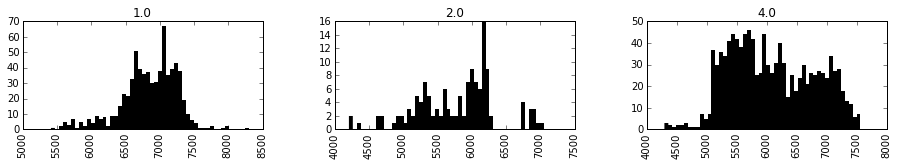

In [15]:
logs.IP.hist(bins=50, color='black', by=logs.LFC, figsize=(15,2), layout=(1,3), lw=0)
#plt.savefig("histograms.png", dpi=250)

## Summary plots

First I need a custom colormap for my classes, i.e. a discrete colormap with following classes-colors association:

* LFC=0: undef, GRAY
* LFC=1: brine sand, BLUE
* LFC=2: oil sand, GREEN
* LFC=3: gas sand, RED
* LFC=4: shale, BROWN

This is the way to define this colormap:

In [16]:
import matplotlib.colors as colors
#      0=undef   1=bri  2=oil   3=gas 4=shale
ccc = ['#B3B3B3','blue','green','red','#996633',]
cmap_facies = colors.ListedColormap(ccc[0:len(ccc)], 'indexed')

Let's now display a summary view of all the logs:

[]

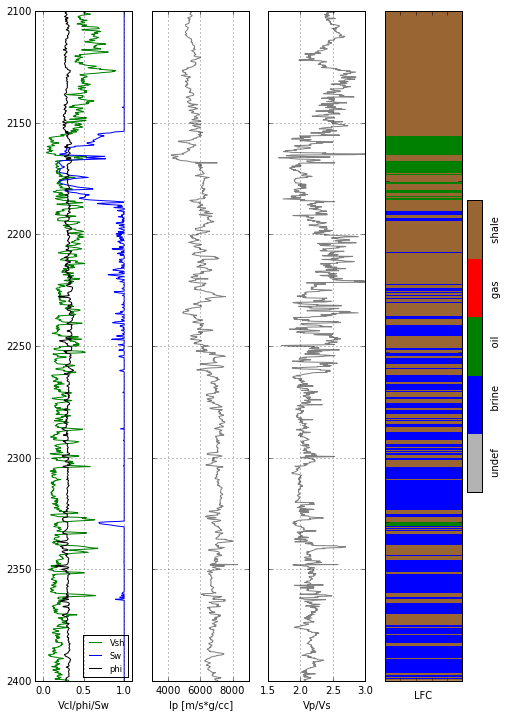

In [17]:
ztop=2100; zbot=2400
ll=logs.ix[(logs.DEPTH>=ztop) & (logs.DEPTH<=zbot)]

cluster=np.repeat(np.expand_dims(ll['LFC'].values,1), 100, 1)

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(8, 12))
ax[0].plot(ll.VSH, ll.DEPTH, '-g', label='Vsh')
ax[0].plot(ll.SW, ll.DEPTH, '-b', label='Sw')
ax[0].plot(ll.PHI, ll.DEPTH, '-k', label='phi')
ax[1].plot(ll.IP, ll.DEPTH, '-', color='0.5')
ax[2].plot(ll.VPVS, ll.DEPTH, '-', color='0.5')
im=ax[3].imshow(cluster, interpolation='none', aspect='auto',cmap=cmap_facies,vmin=0,vmax=4)

cbar=plt.colorbar(im, ax=ax[3])
# cbar.set_label('0=undef,1=brine,2=oil,3=gas,4=shale')
# cbar.set_ticks(range(0,4+1)); cbar.set_ticklabels(range(0,4+1))
cbar.set_label((12*' ').join(['undef', 'brine', 'oil', 'gas', 'shale']))
cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')

for i in range(len(ax)-1):
    ax[i].set_ylim(ztop,zbot)
    ax[i].invert_yaxis()
    ax[i].grid()
    ax[i].locator_params(axis='x', nbins=4)
ax[0].legend(fontsize='small', loc='lower right')
ax[0].set_xlabel("Vcl/phi/Sw"),    ax[0].set_xlim(-.1,1.1)
ax[1].set_xlabel("Ip [m/s*g/cc]"), ax[1].set_xlim(3000,9000)
ax[2].set_xlabel("Vp/Vs"),         ax[2].set_xlim(1.5,3)
ax[3].set_xlabel('LFC')
ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([]); ax[3].set_xticklabels([])

#plt.savefig("log.png", dpi=250)

Now let's see the same data in crossplot domain that should be familiar to geophysicists, i.e. acoustic impedance (Ip) versus Vp/Vs ratio:

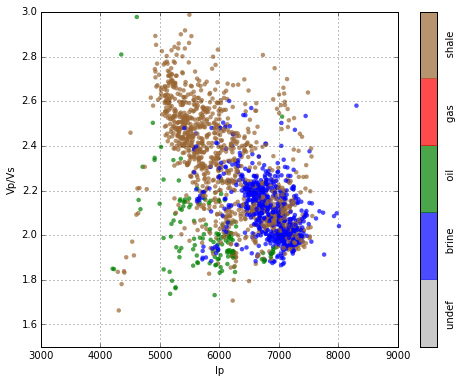

In [18]:
plt.figure(figsize=(8,6))

plt.scatter(logs.IP, logs.VPVS,20, c=logs.LFC,
            marker='o', edgecolors='none',
            alpha=0.7, cmap=cmap_facies,
            vmin=0, vmax=4)
plt.xlim(3000, 9000); plt.ylim(1.5, 3);
plt.xlabel('Ip'); plt.ylabel('Vp/Vs')
plt.grid();

cbar = plt.colorbar()
cbar.set_label((15*' ').join(['undef', 'brine', 'oil', 'gas', 'shale']))
cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')

#plt.savefig("crossplot.png", dpi=250)

The colors are the same as above; but what about that red color? Well, that points to gas sands -- but so far we don't have gas sands in here. In the next tutorial, I will show how to synthesize gas sands and create an additional _gas sand_ class. 

## References

* Avseth, P., Mukerji, T. & Mavko, G. Quantitative Seismic Interpretation. (Cambridge University Press, 2005).


See also the awesome collection of tutorials curated by Matt Hall for [The Leading Edge](http://library.seg.org/journal/leedff) and available here: <https://github.com/seg/tutorials>

<hr />
<p style="color:gray">©2015 Alessandro Amato del Monte, openly licensed under the terms of <a href="https://creativecommons.org/licenses/by-sa/4.0/">CC-BY-SA</a>. This tutorial appeared in SEG Leading Edge in April 2015. </p>